In [1]:
#importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import datasets, metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

### Model 9:

Model will evaluate impact on Sale Price of:
- Neighborhood
- Lot size (log transform)
- House size (feature engineering; log transform)
- Bedrooms 
- Bathrooms (feature engineering)
- Home type (dummy)
- Bldg type (dummy)
- Cost/Sqft (calculated by neighborhood, as the median house cost divided by the average sqft)
- Garage Cars 
- Overall Qual

#### Feature engineering

**Neighborhood (N_< >)**

In [3]:
%store -r joined_df
%store -r df_no_na
enc = OneHotEncoder()
cols = ["Neighborhood"]
column_name = []
for col in cols:
    column_name += [f"{col[0]}_{cat}" for cat in list(df_no_na[col].unique())]
column_name

enc_data_prep = enc.fit_transform(df_no_na[['Neighborhood']]).toarray()
enc_data_area = pd.DataFrame(enc_data_prep, columns=column_name)
joined_df_1 = joined_df.join(enc_data_area)

In [6]:
#repeat for test data
%store -r df_test_no_na
%store -r joined_test_df

cols = ["Neighborhood"]
column_name_test = []
for col in cols:
    column_name_test += [f"{col[0]}_{cat}" for cat in list(df_test_no_na[col].unique())]
column_name_test

enc_data_prep = enc.fit_transform(df_test_no_na[['Neighborhood']]).toarray()
enc_data_area = pd.DataFrame(enc_data_prep, columns=column_name_test)
joined_test_df_1 = joined_test_df.join(enc_data_area)

<br>

**House Style (H_< >)**

In [4]:
cols_hs = ["House Style"]
column_name_hs = []
for col in cols_hs:
    column_name_hs += [f"{col[0]}_{cat}" for cat in list(df_no_na[col].unique())]
column_name_hs

enc_data_hs = enc.fit_transform(df_no_na[['House Style']]).toarray()
enc_data_hs_ = pd.DataFrame(enc_data_hs, columns=column_name_hs)
joined_df_9 = joined_df_1.join(enc_data_hs_)

In [7]:
cols = ["House Style"]
column_name_test_hs = []
for col in cols:
    column_name_test_hs += [f"{col[0]}_{cat}" for cat in list(df_test_no_na[col].unique())]
column_name_test_hs

enc_data_prep_hs = enc.fit_transform(df_test_no_na[['House Style']]).toarray()
enc_data_hs_ = pd.DataFrame(enc_data_prep_hs, columns=column_name_test_hs)
joined_test_df_9 = joined_test_df_1.join(enc_data_hs_)

<br>

**Building Type (B_< >)**

In [5]:
cols_bt = ["Bldg Type"]
column_name_bt = []
for col in cols_bt:
    column_name_bt += [f"{col[0]}_{cat}" for cat in list(df_no_na[col].unique())]
column_name_bt

enc_data_bt = enc.fit_transform(df_no_na[['Bldg Type']]).toarray()
enc_data_bt_ = pd.DataFrame(enc_data_bt, columns=column_name_bt)
joined_df_91 = joined_df_9.join(enc_data_bt_)

In [8]:
cols = ["Bldg Type"]
column_name_test_bt = []
for col in cols:
    column_name_test_bt += [f"{col[0]}_{cat}" for cat in list(df_test_no_na[col].unique())]
column_name_test_bt

enc_data_prep_bt = enc.fit_transform(df_test_no_na[['Bldg Type']]).toarray()
enc_data_bt_ = pd.DataFrame(enc_data_prep_bt, columns=column_name_test_bt)
joined_test_df_91 = joined_test_df_9.join(enc_data_bt_)

<br>

**House and Lot Area**

Assumption:
* Both of these variables have a slight skew and were log-transformed for a more straight forward regression model

In [18]:
joined_df_91["Transform_Lot_Area"] = np.log10(joined_df_91["Lot Area"])
joined_df_91["Transform_Total_SF"] = np.log10(joined_df_91["Total_SF"])

In [10]:
joined_test_df_91["Transform_Lot_Area"] = np.log10(joined_test_df_91["Lot Area"])
joined_test_df_91["Transform_Total_SF"] = np.log10(joined_test_df_91["Total_SF"])

In [16]:
#this code was supposed to help reconcile column differences across dataframes, but doesn't seem to do the trick
#cols_align = []

#for (colname,colvalue) in joined_df_91.items():
#    if colname not in joined_test_df_91.items():
#        cols_align.append(colname)
#    if i == "SalePrice":
#        continue
#        for i in cols_align:
#            joined_test_df_91[i]
#len(cols_align)

In [21]:
#create missing columns
joined_df_91["B_2fmCon"]=0
joined_df_91["B_Duplex"]=0

joined_test_df_91["N_GrnHill"]=0
joined_test_df_91["N_Landmrk"]=0

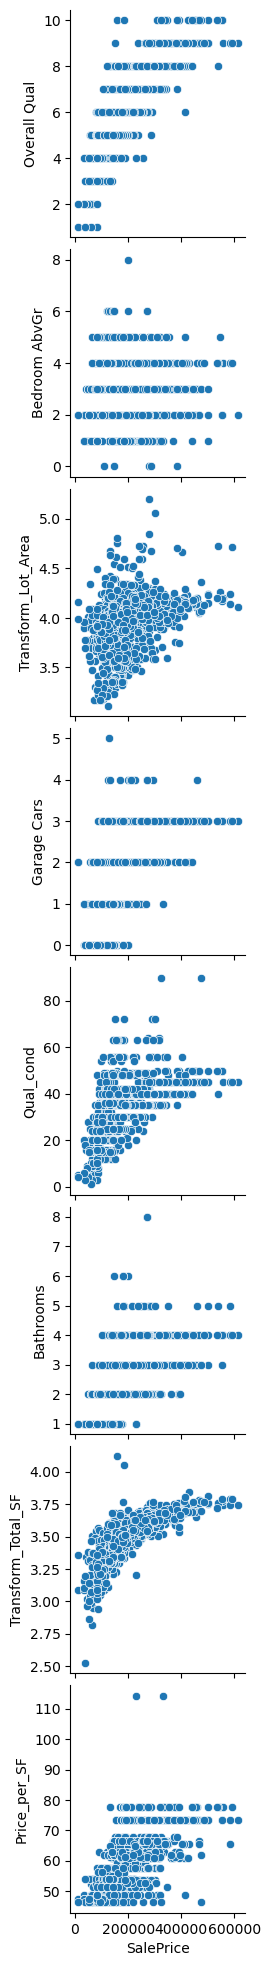

In [67]:
sns.pairplot(joined_df_91, y_vars=["Overall Qual",
                   "Bedroom AbvGr",
                   "Transform_Lot_Area",
                   "Garage Cars",  "Qual_cond",
                   "Bathrooms",    "Transform_Total_SF",
                   "Price_per_SF"], x_vars=['SalePrice']);

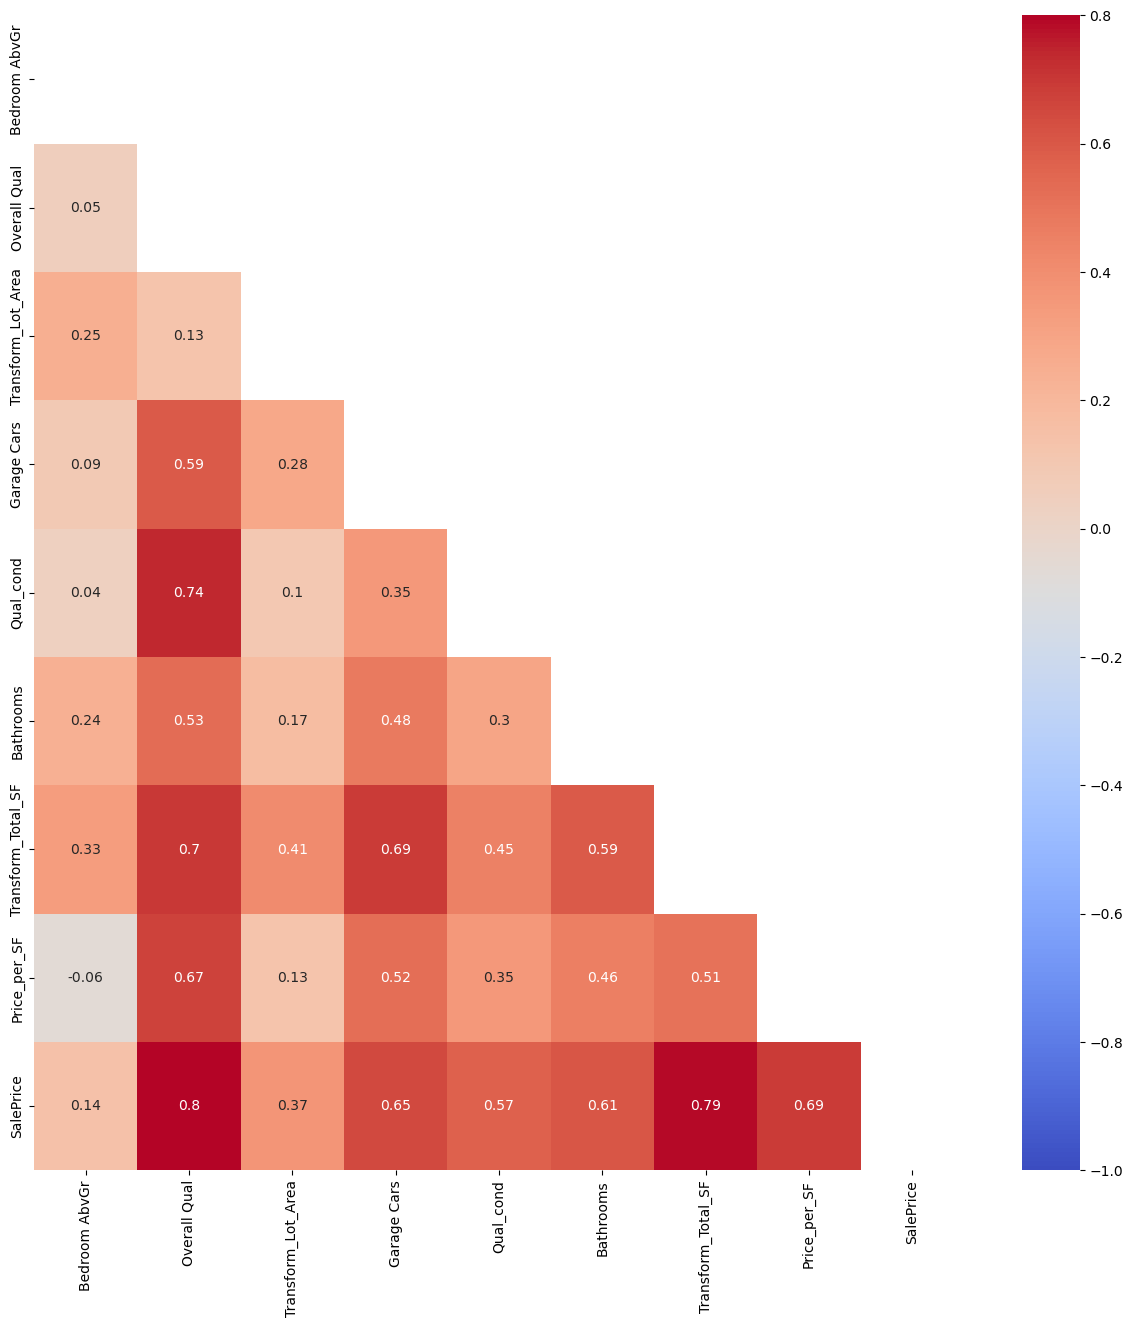

In [70]:
fig, ax = plt.subplots(figsize = (15,15))
mask = np.triu(np.ones_like(joined_df_91[["Bedroom AbvGr","Overall Qual",
                   "Transform_Lot_Area",
                   "Garage Cars",  "Qual_cond",
                   "Bathrooms",    "Transform_Total_SF",
                   "Price_per_SF","SalePrice"]].corr(), dtype=bool))
sns.heatmap(round(joined_df_91[["Bedroom AbvGr", "Overall Qual",
                   "Transform_Lot_Area",
                   "Garage Cars",  "Qual_cond",
                   "Bathrooms",    "Transform_Total_SF",
                   "Price_per_SF","SalePrice"]].corr(),2), annot=True, mask = mask, cmap="coolwarm", vmin=-1);

### Model - Lasso Regression

In [22]:
df_no_na_model9 = joined_df_91[["Overall Qual",
                   "Bedroom AbvGr",
                   "Transform_Lot_Area",
                   "Garage Cars",  "Qual_cond",
                   "Bathrooms",    "Transform_Total_SF",
                   "Price_per_SF",
 'N_Sawyer',
 'N_SawyerW',
 'N_NAmes',
 'N_Timber',
 'N_Edwards',
 'N_OldTown',
 'N_BrDale',
 'N_CollgCr',
 'N_Somerst',
 'N_Mitchel',
 'N_StoneBr',
 'N_NridgHt',
 'N_Gilbert',
 'N_Crawfor',
 'N_IDOTRR',
 'N_NWAmes',
 'N_Veenker',
 'N_MeadowV',
 'N_SWISU',
 'N_NoRidge',
 'N_ClearCr',
 'N_Blmngtn',
 'N_BrkSide',
 'N_NPkVill',
 'N_Blueste',
 'N_GrnHill',
 'N_Greens',
 'N_Landmrk',
 'H_2Story',
 'H_1Story',
 'H_1.5Fin',
 'H_SFoyer',
 'H_SLvl',
 'H_2.5Unf',
 'H_2.5Fin',
 'H_1.5Unf',
 'B_1Fam',
 'B_TwnhsE',
 'B_Twnhs',
 'B_2fmCon',
 'B_Duplex', "SalePrice"]]

In [23]:
df_test_no_na_model9 = joined_test_df_91[["Overall Qual",
                   "Bedroom AbvGr",
                   "Transform_Lot_Area",
                   "Garage Cars",  "Qual_cond",
                   "Bathrooms",    "Transform_Total_SF",
                   "Price_per_SF",
 'N_Sawyer',
 'N_SawyerW',
 'N_NAmes',
 'N_Timber',
 'N_Edwards',
 'N_OldTown',
 'N_BrDale',
 'N_CollgCr',
 'N_Somerst',
 'N_Mitchel',
 'N_StoneBr',
 'N_NridgHt',
 'N_Gilbert',
 'N_Crawfor',
 'N_IDOTRR',
 'N_NWAmes',
 'N_Veenker',
 'N_MeadowV',
 'N_SWISU',
 'N_NoRidge',
 'N_ClearCr',
 'N_Blmngtn',
 'N_BrkSide',
 'N_NPkVill',
 'N_Blueste',
 'N_GrnHill',
 'N_Greens',
 'N_Landmrk',
 'H_2Story',
 'H_1Story',
 'H_1.5Fin',
 'H_SFoyer',
 'H_SLvl',
 'H_2.5Unf',
 'H_2.5Fin',
 'H_1.5Unf',
 'B_1Fam',
 'B_TwnhsE',
 'B_Twnhs',
 'B_2fmCon',
 'B_Duplex']]

In [24]:
df_no_na_model9.dropna(how = "any", inplace = True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_47849/3607039797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na_model9.dropna(how = "any", inplace = True)


In [25]:
df_test_no_na_model9.dropna(how = "any", inplace = True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_47849/2325797472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_no_na_model9.dropna(how = "any", inplace = True)


In [27]:
X9 = df_no_na_model9.drop(['SalePrice','N_Sawyer','H_SLvl','B_2fmCon'], axis=1)
y9 = df_no_na_model9["SalePrice"]

In [30]:
X9_to_test = df_test_no_na_model9.drop(['N_Sawyer','H_SLvl','B_2fmCon'], axis=1)

In [32]:
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, random_state=42)

In [33]:
ss = StandardScaler()
#ss.fit(X_train)
X9_train = ss.fit_transform(X9_train)
X9_test = ss.transform(X9_test)

In [34]:
X9_to_test = ss.transform(X9_to_test)

In [35]:
lasso_9 = Lasso(alpha=1)
lasso_9.fit(X9_train, y9_train)

Lasso(alpha=1)

In [36]:
print('R2 training data', round(lasso_9.score(X9_train, y9_train), 2))
print('R2 test data', round(lasso_9.score(X9_test, y9_test), 2))

R2 training data 0.84
R2 test data 0.83


In [37]:
pred_train9 = lasso_9.predict(X9_train)
mse_train9 = mean_squared_error(y9_train, pred_train9)
print('RMSE training data', round(mse_train9**0.5, 2))

# Test data
pred9 = lasso_9.predict(X9_test)
mse_test9 = mean_squared_error(y9_test, pred9)
print('RMSE test data', round(mse_test9**0.5, 2))

RMSE training data 31825.7
RMSE test data 31776.44


In [38]:
model_lasso_9 = LassoCV(cv=8, random_state=0, max_iter=10000)
model_lasso_9.fit(X9_train, y9_train)

LassoCV(cv=8, max_iter=10000, random_state=0)

In [39]:
lasso_9_best = Lasso(alpha=model_lasso_9.alpha_)
lasso_9_best.fit(X9_train, y9_train)

Lasso(alpha=147.2932885346603)

In [40]:
print('R2 training data', round(lasso_9_best.score(X9_train, y9_train), 2))
print('R2 test data', round(lasso_9_best.score(X9_test, y9_test), 2))
pred_train9_best = lasso_9_best.predict(X9_train)
mse_train9_best = mean_squared_error(y9_train, pred_train9_best)
print('RMSE training data', round(mse_train9_best**0.5, 2))

# Test data
pred9_best = lasso_9_best.predict(X9_test)
mse_test9_best = mean_squared_error(y9_test, pred9_best)
print('RMSE test data', round(mse_test9_best**0.5, 2))

R2 training data 0.84
R2 test data 0.83
RMSE training data 31935.86
RMSE test data 31773.47


In [42]:
%store -r df_test
submission9 = pd.DataFrame(df_test, columns=["Id"])
submission9["SalePrice"] = lasso_9_best.predict(X9_to_test)

In [44]:
submission9.to_csv('./datasets/submission9.csv', index=False)

### Model Validation

In [66]:
summary = pd.DataFrame(lasso_9_best.coef_, index=("Overall Qual",
                   "Bedroom AbvGr",
                   "Transform_Lot_Area",
                   "Garage Cars",  "Qual_cond",
                   "Bathrooms",    "Transform_Total_SF",
                   "Price_per_SF",

 'N_SawyerW',
 'N_NAmes',
 'N_Timber',
 'N_Edwards',
 'N_OldTown',
 'N_BrDale',
 'N_CollgCr',
 'N_Somerst',
 'N_Mitchel',
 'N_StoneBr',
 'N_NridgHt',
 'N_Gilbert',
 'N_Crawfor',
 'N_IDOTRR',
 'N_NWAmes',
 'N_Veenker',
 'N_MeadowV',
 'N_SWISU',
 'N_NoRidge',
 'N_ClearCr',
 'N_Blmngtn',
 'N_BrkSide',
 'N_NPkVill',
 'N_Blueste',
 'N_GrnHill',
 'N_Greens',
 'N_Landmrk',
 'H_2Story',
 'H_1Story',
 'H_1.5Fin',
 'H_SFoyer',

 'H_2.5Unf',
 'H_2.5Fin',
 'H_1.5Unf',
 'B_1Fam',
 'B_TwnhsE',
 'B_Twnhs',

 'B_Duplex'))
summary.columns = ["Coefficient"]
summary.sort_values("Coefficient", ascending=False)

,Coefficient
Transform_Total_SF,20679.428138
Price_per_SF,18181.526801
Overall Qual,18052.179815
Bathrooms,14393.282867
B_1Fam,9455.917025
Transform_Lot_Area,7719.207977
Qual_cond,7364.002084
N_NoRidge,7351.973707
N_GrnHill,5723.263161
N_Crawfor,4968.447389


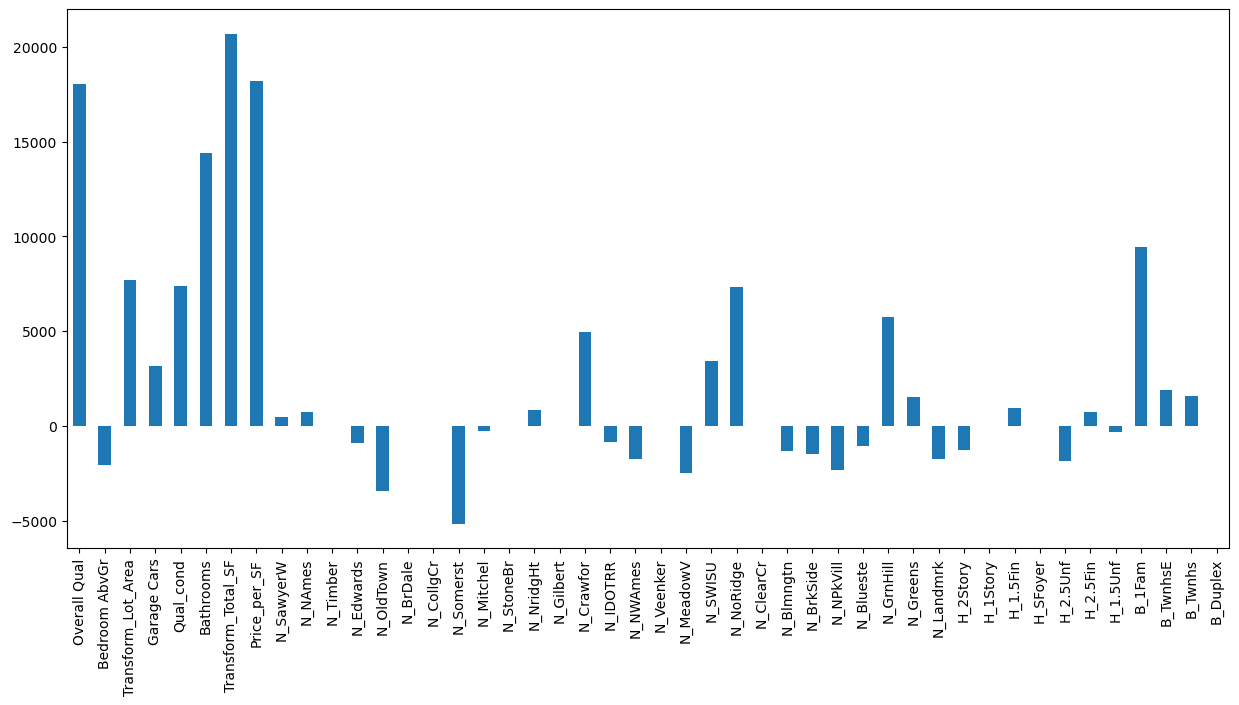

In [45]:
pd.Series(lasso_9_best.coef_, index=("Overall Qual",
                   "Bedroom AbvGr",
                   "Transform_Lot_Area",
                   "Garage Cars",  "Qual_cond",
                   "Bathrooms",    "Transform_Total_SF",
                   "Price_per_SF",

 'N_SawyerW',
 'N_NAmes',
 'N_Timber',
 'N_Edwards',
 'N_OldTown',
 'N_BrDale',
 'N_CollgCr',
 'N_Somerst',
 'N_Mitchel',
 'N_StoneBr',
 'N_NridgHt',
 'N_Gilbert',
 'N_Crawfor',
 'N_IDOTRR',
 'N_NWAmes',
 'N_Veenker',
 'N_MeadowV',
 'N_SWISU',
 'N_NoRidge',
 'N_ClearCr',
 'N_Blmngtn',
 'N_BrkSide',
 'N_NPkVill',
 'N_Blueste',
 'N_GrnHill',
 'N_Greens',
 'N_Landmrk',
 'H_2Story',
 'H_1Story',
 'H_1.5Fin',
 'H_SFoyer',

 'H_2.5Unf',
 'H_2.5Fin',
 'H_1.5Unf',
 'B_1Fam',
 'B_TwnhsE',
 'B_Twnhs',

 'B_Duplex')).plot.bar(figsize = (15, 7));


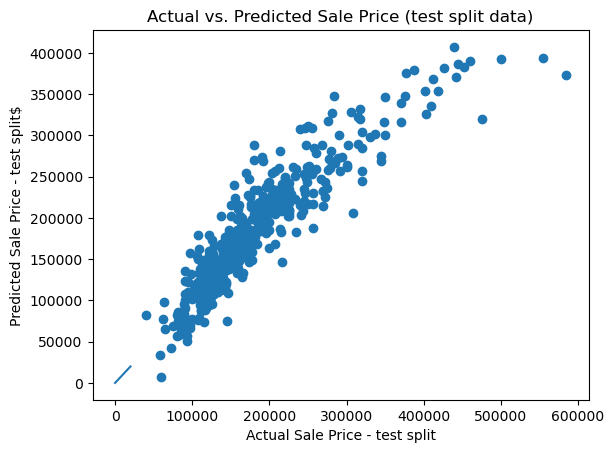

In [46]:
plt.scatter(y9_test, pred9)
plt.plot(range(20000), range(20000))

plt.xlabel("Actual Sale Price - test split")
plt.ylabel("Predicted Sale Price - test split$")
plt.title("Actual vs. Predicted Sale Price (test split data)")

plt.show()

In [51]:
import statsmodels.api as sm

In [52]:
ols_9 = sm.OLS(y9, X9)

In [53]:
fitOLS = ols_9.fit()

In [54]:
fitOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     241.1
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:25:26   Log-Likelihood:                -24123.
No. Observations:                2048   AIC:                         4.834e+04
Df Residuals:                    2003   BIC:                         4.859e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Overall Qual        1.373e+04   1245.483     11.024      0.000    1.13e+04    1.62e+04
Bedroom AbvGr      -3235.0621   1201.465     -2.693      0.007   -5591.313    -878.811
Transform_Lot_Area  4.846e+04   5628.267      8.610      0.000    3.74e+04    5.95e+04
Garage Cars         3942.3319   1438.789      2.740      0.006    1120.651    6764.013
Qual_cond            728.5662    129.606      5.621      0.000     474.390     982.743
Bathrooms           1.497e+04   1138.079     13.157      0.000    1.27e+04    1.72e+04
Transform_Total_SF  1.538e+05   1.08e+04     14.247      0.000    1.33e+05    1.75e+05
Price_per_SF       -1.153e+04    592.464    -19.461      0.000   -1.27e+04   -1.04e+04
N_SawyerW          -4.949e+04   1.47e+04     -3.371      0.001   -7.83e+04   -2.07e+04
N_NAmes            -4.386e+04   1.01e+04     -4.341      0.000   -6.37e+04    -2.4e+04
N_Timber           -9.335e+04   8576.061    -10.885      0.000    -1.1e+05   -7.65e+04
N_Edwards            4.07e+04   1.06e+04      3.839      0.000    1.99e+04    6.15e+04
N_OldTown          -2051.3330   8228.877     -0.249      0.803   -1.82e+04    1.41e+04
N_BrDale            2.515e+04   9007.481      2.792      0.005    7487.651    4.28e+04
N_CollgCr          -1.644e+05   9395.927    -17.498      0.000   -1.83e+05   -1.46e+05
N_Somerst          -1.691e+04   8515.113     -1.986      0.047   -3.36e+04    -214.440
N_Mitchel           4.724e+04   2.01e+04      2.345      0.019    7732.047    8.67e+04
N_StoneBr            7.27e+05   4.11e+04     17.683      0.000    6.46e+05    8.08e+05
N_NridgHt          -1.782e+05   1.01e+04    -17.557      0.000   -1.98e+05   -1.58e+05
N_Gilbert          -5.396e+04   3.27e+04     -1.650      0.099   -1.18e+05    1.02e+04
N_Crawfor          -1.402e+05   1.13e+04    -12.361      0.000   -1.62e+05   -1.18e+05
N_IDOTRR           -1.052e+05   8596.947    -12.233      0.000   -1.22e+05   -8.83e+04
N_NWAmes           -1.335e+05   8490.342    -15.728      0.000    -1.5e+05   -1.17e+05
N_Veenker          -7.268e+04   1.03e+04     -7.051      0.000   -9.29e+04   -5.25e+04
N_MeadowV          -1.249e+05   8787.213    -14.209      0.000   -1.42e+05   -1.08e+05
N_SWISU              9.28e+04   9961.727      9.316      0.000    7.33e+04    1.12e+05
N_NoRidge           1.988e+05    1.2e+04     16.619      0.000    1.75e+05    2.22e+05
N_ClearCr          -1.961e+05      1e+04    -19.537      0.000   -2.16e+05   -1.76e+05
N_Blmngtn          -1.262e+05   9826.764    -12.839      0.000   -1.45e+05   -1.07e+05
N_BrkSide          -1.054e+05   8402.197    -12.547      0.000   -1.22e+05   -8.89e+04
N_NPkVill          -5.821e+04   8139.725     -7.151      0.000   -7.42e+04   -4.22e+04
N_Blueste             7.2e+04   9373.223      7.681      0.000    5.36e+04    9.04e+04
N_GrnHill           2.655e+05   1.46e+

In [56]:
ridge9 = RidgeCV(alphas=np.linspace(.1, 10, 100))
ridge_scores = cross_val_score(ridge9, X9_train, y9_train, cv = 3)
ridge_scores.mean()

0.8252554347181268